# Viking20x Labrador Sea budget


### Navigate with arrows, across and down (usually down to see the plots, across for next category). Presentation plan can be revealed with the Esc key.

- reads in section data produced on GEOMAR JupyterLab
- plots the section data
- calculates densities
- budget in density space

In [168]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as c
import matplotlib.dates as mdates
from matplotlib import ticker
import seaborn as sns
import cmocean as co 
from xhistogram.xarray import histogram
import seawater as sw
from scipy import signal


import importlib
import sys

###  xorca_brokenline and xorca_lonlatij imported from local folder ../../src

If these are in the python environment then can import direct from there.

Note: This needs the latest (early 2022) xorca_brokenline from the repo with the fixed interpolation. **Not the latest labelled version v1.1.1**

In [169]:
# path to some plotting routines
sys.path.append(r'../../src/')

In [170]:
import xorca_brokenline as bl
from xorca_lonlat2ij import get_ij

In [171]:
sns.set(style="whitegrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

In [172]:
def butter_lowpass(cutoff, fs, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = signal.butter(order, normal_cutoff, btype='low', analog=False, output='sos')
    return sos

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    sos = butter_lowpass(cutoff, fs, order=order)
    y = signal.sosfiltfilt(sos, data,padtype='even',padlen=50)
    return y

In [173]:
def lowpass_filter(timser):
    timser_mean = timser.mean()
    timser_filtered = xr.apply_ufunc(butter_lowpass_filtfilt, timser-timser_mean,cutoff,fs,
                     dask='parallelized')
    return timser_filtered + timser_mean


In [174]:
fs = 12.0  #samples per year
cutoff = 0.5


### Set up paths and read in data

In [175]:
# paramters

# Project path
path_project = Path.cwd() / '..' / '..' 
path_project = path_project.resolve()

# Section data file
path_data_input = path_project / 'data/interim/sections'

# figures
path_figures = path_project / 'reports/figures/osnapSection'



In [176]:
section_files = (path_data_input).glob(f"sectionOSNAP*.nc")
section_files = list(sorted(section_files))
print(f"found {len(section_files)} section files")


found 30 section files


In [177]:
section_osnap = xr.open_mfdataset(
    section_files,
    combine='by_coords'
)


In [178]:
section_osnap['ii']=section_osnap.ii.isel(time_counter=0).drop('time_counter')
section_osnap['jj']=section_osnap.jj.isel(time_counter=0).drop('time_counter')
section_osnap['dx']=section_osnap.dx.isel(time_counter=0).drop('time_counter')
section_osnap['lat']=section_osnap.lat.isel(time_counter=0).drop('time_counter')
section_osnap['lon']=section_osnap.lon.isel(time_counter=0).drop('time_counter')
section_osnap['dz']=section_osnap.dz.isel(time_counter=0).drop('time_counter')
section_osnap['mask']=section_osnap.mask.isel(time_counter=0).drop('time_counter')



In [179]:
section_osnap

<xarray.Dataset>
Dimensions:       (c: 1280, z: 46, time_counter: 360)
Coordinates:
  * c             (c) float64 3.502e+03 7.005e+03 ... 4.225e+06 4.229e+06
  * z             (z) float32 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time_counter  (time_counter) datetime64[ns] 1990-01-16T12:00:00 ... 2019-...
Data variables: (12/14)
    u_normal      (time_counter, z, c) float64 dask.array<chunksize=(12, 46, 1280), meta=np.ndarray>
    tau_normal    (time_counter, c) float64 dask.array<chunksize=(12, 1280), meta=np.ndarray>
    u_along       (time_counter, z, c) float64 dask.array<chunksize=(12, 46, 1280), meta=np.ndarray>
    tau_along     (time_counter, c) float64 dask.array<chunksize=(12, 1280), meta=np.ndarray>
    votemper      (time_counter, z, c) float32 dask.array<chunksize=(12, 46, 1280), meta=np.ndarray>
    vosaline      (time_counter, z, c) float32 dask.array<chunksize=(12, 46, 1280), meta=np.ndarray>
    ...            ...
    jj            (c) int64 dask.array<chunksize=(1280,), meta=np.ndarray>
    dx            (c) float64 dask.array<chunksize=(1280,), meta=np.ndarray>
    lat           (c) float32 dask.array<chunksize=(1280,), meta=np.ndarray>
    lon           (c) float32 dask.array<chunksize=(1280,), meta=np.ndarray>
    dz            (z, c) float64 dask.array<chunksize=(46, 1280), meta=np.ndarray>
    mask          (z, c) float32 dask.array<chunksize=(46, 1280), meta=np.ndarray>

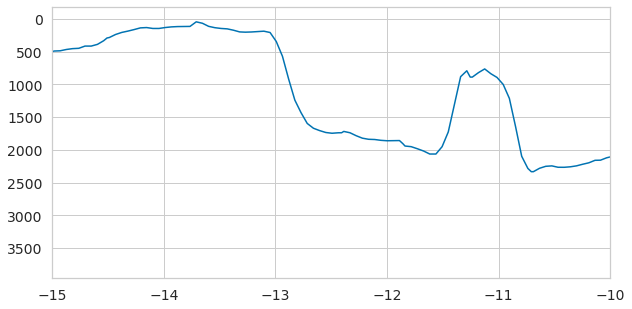

In [180]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(section_osnap.lon,(section_osnap.mask*section_osnap.dz).sum(dim='z'))
ax.set_xlim(-15,-10)
ax.invert_yaxis()


In [181]:
# add some missing attributes, mostly for automatic axis labels
# there is presumably a neater way to do this with a dictionary

section_osnap.vosaline.attrs['long_name']='salinity'
section_osnap.vosaline.attrs['units']='PSU'
section_osnap.votemper.attrs['long_name']='potential temperature'
section_osnap.votemper.attrs['units']='$\degree C$'
section_osnap.c.attrs['long_name']='Distance'
section_osnap.c.attrs['units']='m'
section_osnap.z.attrs['long_name']='Depth'
section_osnap.z.attrs['units']='m'
section_osnap.time_counter.attrs["long_name"] = 'Time'



### add sigma-0 to section datafile

In [182]:
# osnap
S = section_osnap.vosaline.data
T = section_osnap.votemper.data
sig0 = sw.pden(S,T,0.0,0.0)
sig0 -= 1000.0
section_osnap = section_osnap.assign({"vosigma0":(("time_counter", "z", "c"),sig0)})


In [183]:
section_osnap = section_osnap.isel(time_counter=slice(288,None,1))

### plot an example vertical section

In [184]:
def plot_section(section):    
    fig,ax = plt.subplots(figsize=(15,5))
    # whole section
    section.isel(c=slice(None,None,1))['u_normal'].isel(time_counter=25).plot(cmap=co.cm.balance)
    section.isel(c=slice(None,None,1))['mask'].where(section['mask']==0).plot(cmap=c.ListedColormap(['gray']),add_colorbar=0)
    CS = section.isel(c=slice(None,None,1))['vosigma0'].isel(time_counter=25).plot.contour(cmap=co.cm.dense,vmin=27.5,vmax=27.8)
    ax.set_ylim(0,4000)
    fig.gca().invert_yaxis()
    ax.clabel(CS, inline=True, fontsize=8,fmt='%1.2f',inline_spacing=2)
    ax.set_ylabel("Depth (m)")
    ax.set_xlabel("Distance (m)")
    ax.set_title(np.datetime_as_string(section.time_counter[25].data,unit='D')+" Velocity normal to section. Positive into page.")
    return

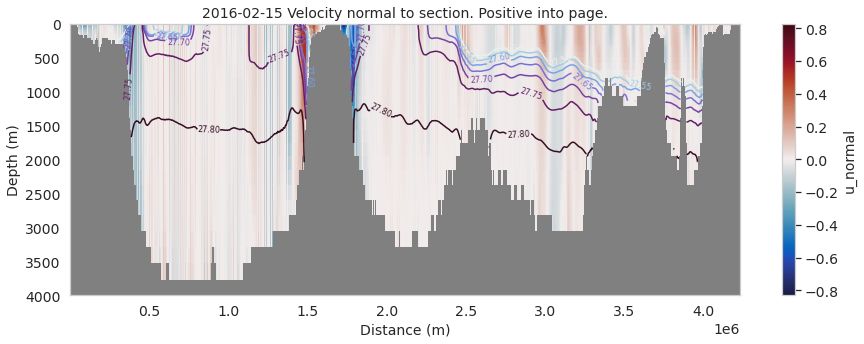

In [185]:
plot_section(section_osnap)
# plt.savefig(project_path / data_path / 'Viking20x_OSNAP_greenland_currents_2016-02-15.png')


### split out east and west

In [186]:
section_owest = section_osnap.isel(c=slice(None,500,1))
section_oeast = section_osnap.isel(c=slice(500,None,1))


### calculate transports into labrador sea

resulting arrays hold volume, heat and freshwater transports

reference salinity can be supplied S_ref (default 34.8).

In [187]:
transport_osnap = bl.calculate_transport(section_osnap,S_ref=34.92)
transport_osnap.trsp.attrs["long_name"] = 'volume transport'
transport_osnap.trsp.attrs["units"] = 'Sv'
transport_osnap.ht_trsp.attrs["long_name"] = 'heat transport'
transport_osnap.ht_trsp.attrs["units"] = 'W'
transport_osnap.fw_trsp.attrs["long_name"] = 'freshwater transport'
transport_osnap.fw_trsp.attrs["units"] = 'Sv'
transport_owest = bl.calculate_transport(section_owest,S_ref=34.92)
transport_owest.trsp.attrs["long_name"] = 'volume transport'
transport_owest.trsp.attrs["units"] = 'Sv'
transport_owest.ht_trsp.attrs["long_name"] = 'heat transport'
transport_owest.ht_trsp.attrs["units"] = 'W'
transport_owest.fw_trsp.attrs["long_name"] = 'freshwater transport'
transport_owest.fw_trsp.attrs["units"] = 'Sv'
transport_oeast = bl.calculate_transport(section_oeast,S_ref=34.92)
transport_oeast.trsp.attrs["long_name"] = 'volume transport'
transport_oeast.trsp.attrs["units"] = 'Sv'
transport_oeast.ht_trsp.attrs["long_name"] = 'heat transport'
transport_oeast.ht_trsp.attrs["units"] = 'W'
transport_oeast.fw_trsp.attrs["long_name"] = 'freshwater transport'
transport_oeast.fw_trsp.attrs["units"] = 'Sv'


## calculate overturning streamfunction

In [188]:
def calculate_amoc(section2):
    """ Calculate transports binned on sigma layers

    Parameters
    ----------
    section: xarray.Dataset
        Dataset returned by broken_line.section() with vosigma0 added
  
    Returns
    -------
    trsp : xarray.Dataset
        Dataset of shape (t,sigma)
        "t" - time
        "sigma" - density bins

    """
    # Volume transport
    trsp = section2['u_normal'] * section2['dx'] * section2['dz'] / 1e06
    
    sigbins = np.arange(10.0,28.001, 0.01)

    trsp_sigma = histogram(section2.vosigma0, bins=[sigbins], dim=["z","c"], weights=trsp)
    trsp_sigma.attrs["long_name"]='MOC'
    trsp_sigma.vosigma0_bin.attrs["long_name"]= r'$\sigma_{\theta}$'
    trsp_sigma.time_counter.attrs["long_name"]= "Date"
    trsp_sigma.vosigma0_bin.attrs["units"]= r'$\mathrm{kg\ m^{-3}}$'
    trsp_sigma.attrs["units"]='Sv'
    
    return trsp_sigma

In [189]:
def calc_amoc(section):
    amoc = calculate_amoc(section)
    return amoc

In [190]:
amoc_osnap = calc_amoc(section_osnap)
amoc_owest = calc_amoc(section_owest)
amoc_oeast = calc_amoc(section_oeast)


In [191]:
# sum from low to high density

amoc_osnap_sumup=amoc_osnap.cumsum(dim="vosigma0_bin")
amoc_owest_sumup=amoc_owest.cumsum(dim="vosigma0_bin")
amoc_oeast_sumup=amoc_oeast.cumsum(dim="vosigma0_bin")


### alternatively, calculate sum from bottom to top (downwards in density from from high to low)

In [192]:

amoc_osnap_sumdown=(amoc_osnap.cumsum(dim="vosigma0_bin",keep_attrs=True)
                    -amoc_osnap.sum(dim="vosigma0_bin",keep_attrs=True))
amoc_owest_sumdown=(amoc_owest.cumsum(dim="vosigma0_bin",keep_attrs=True)
                    -amoc_owest.sum(dim="vosigma0_bin",keep_attrs=True))
amoc_oeast_sumdown=(amoc_oeast.cumsum(dim="vosigma0_bin",keep_attrs=True)
                    -amoc_oeast.sum(dim="vosigma0_bin",keep_attrs=True))


### plot overturning streamfunction vs density class.

Accumulated from low to high density. MOC is the maximum of this streamfunction (blue dots monthly, orange dot overall mean).  
**May need to right-click and 'view image' to get the whole figure.**

In [193]:
def plot_amoc(osnap_sum,osnap_w_sum,osnap_e_sum):
    fig, ax = plt.subplots(2,2,figsize=(15,12),gridspec_kw={'hspace': 0.01, 'wspace': 0.1,'height_ratios': [1, 4]})
    plt.tight_layout()

# split plot vertically to emphasise the higher density levels

# lower density section
    
    (osnap_sum
        .plot.line(ax=ax[0,0],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4))
    (osnap_sum
         .mean(dim='time_counter')
         .plot.line(ax=ax[0,0],y="vosigma0_bin",add_legend=False,color='k',linewidth=2))

    (osnap_w_sum
        .plot.line(ax=ax[0,1],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4))
    (osnap_w_sum
        .mean(dim='time_counter')
        .plot.line(ax=ax[0,1],y="vosigma0_bin",add_legend=False,color='C0',linewidth=2,zorder=10))

    (osnap_e_sum
        .plot.line(ax=ax[0,1],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4))
    (osnap_e_sum
        .mean(dim='time_counter')
        .plot.line(ax=ax[0,1],y="vosigma0_bin",add_legend=False,color='C1',linewidth=2,zorder=10))

# higher density section
    (osnap_sum
         .plot.line(ax=ax[1,0],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4))
    (osnap_sum
         .mean(dim='time_counter')
         .plot.line(ax=ax[1,0],y="vosigma0_bin",add_legend=False,color='k',linewidth=2.0,zorder=10))
#     (osnap_sum
#          .isel(vosigma0_bin=osnap_sum.argmax(dim="vosigma0_bin"))
#          .plot(ax=ax[1,0],y="vosigma0_bin",marker='o',ms=2,linewidth=0))
    
    (osnap_w_sum
         .plot.line(ax=ax[1,1],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4))
    (osnap_w_sum
         .mean(dim='time_counter')
         .plot.line(ax=ax[1,1],y="vosigma0_bin",add_legend=False,color='C0',linewidth=2,zorder=10))
#     (osnap_w_sum
#          .isel(vosigma0_bin=osnap_w_sum.argmax(dim="vosigma0_bin"))
#          .plot(ax=ax[1,1],y="vosigma0_bin",marker='o',ms=2,linewidth=0))
    
    (osnap_e_sum
         .plot.line(ax=ax[1,1],y="vosigma0_bin",add_legend=False,color='darkgrey',linewidth=0.4))
    (osnap_e_sum
         .mean(dim='time_counter')
         .plot.line(ax=ax[1,1],y="vosigma0_bin",add_legend=False,color='C1',linewidth=2,zorder=10))
    
    
    
    ax[1,0].hlines(osnap_sum.mean(dim='time_counter').
                   vosigma0_bin[osnap_sum.mean(dim='time_counter').argmax().compute()],-10,25,
                   color='k',linestyle='--')
    ax[1,1].hlines(osnap_e_sum.mean(dim='time_counter').
                   vosigma0_bin[osnap_e_sum.mean(dim='time_counter').argmax().compute()],-10,25,
                   color='C1',linestyle='--')
    ax[1,1].hlines(osnap_w_sum.mean(dim='time_counter').
                   vosigma0_bin[osnap_w_sum.mean(dim='time_counter').argmax().compute()],-10,25,
                   color='C0',linestyle='--')
    


# set up axes
    ax[0,0].set_ylim([26.99,24.5])
    ax[0,1].set_ylim([26.99,24.5])
    ax[0,0].set_xlim([-10,25])
    ax[0,1].set_xlim([-10,25])

    ax[1,0].set_ylim([28,27])
    ax[1,1].set_ylim([28,27])
    ax[1,0].set_xlim([-10,25])
    ax[1,1].set_xlim([-10,25])
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for axis in ax.flat:
        axis.label_outer()
        
        
    ax[0,0].text(10,25,'Full Array',fontsize=20)
    ax[0,1].text(10,25,'OSNAP West',color='C0',fontsize=20)
    ax[0,1].text(10,25.5,'OSNAP East',color='C1',fontsize=20)


    plt.savefig(path_figures / 'Viking20x_OSNAP_overturning_streamfunction_2014-19.png')
    return

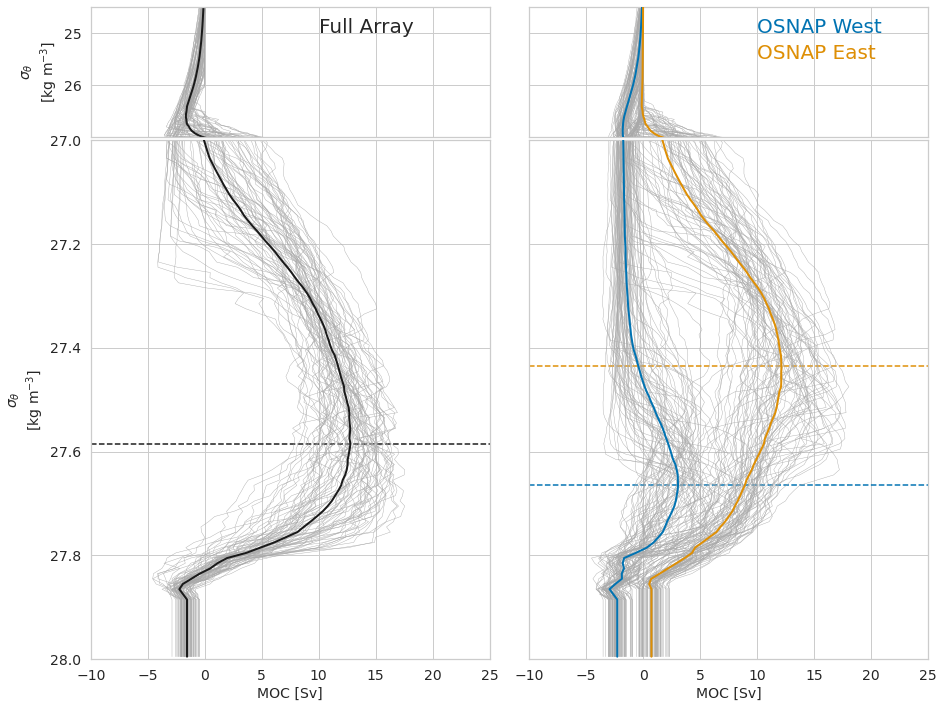

In [194]:
plot_amoc(amoc_osnap_sumup,
          amoc_owest_sumup,
          amoc_oeast_sumup)

In [195]:
def plot_MHT_MFT(transport,transport_W,transport_E):
    fig, ax = plt.subplots(2,figsize=(15,10),sharex=True,gridspec_kw={'hspace': 0.02,'height_ratios': [1, 1]})

    (transport.ht_trsp
        .plot(ax=ax[0],marker='o',ms=2,linewidth=1,color='k',label='Full Array'))
    ((transport_W.ht_trsp)
        .plot(ax=ax[0],marker='o',ms=2,linewidth=1,label='OSNAP West'))
    ((transport_E.ht_trsp)
        .plot(ax=ax[0],marker='o',ms=2,linewidth=1,label='OSNAP East'))

    
    (transport.fw_trsp
         .plot(ax=ax[1],marker='o',ms=2,linewidth=1,color='k',label='Full Array'))
    ((transport_W.fw_trsp)
         .plot(ax=ax[1],marker='o',ms=2,linewidth=1,label='OSNAP West'))
    ((transport_E.fw_trsp)
         .plot(ax=ax[1],marker='o',ms=2,linewidth=1,label='OSNAO East'))
    ax[0].legend()
    ax[1].legend()
    ax[0].set_xlabel('')
    

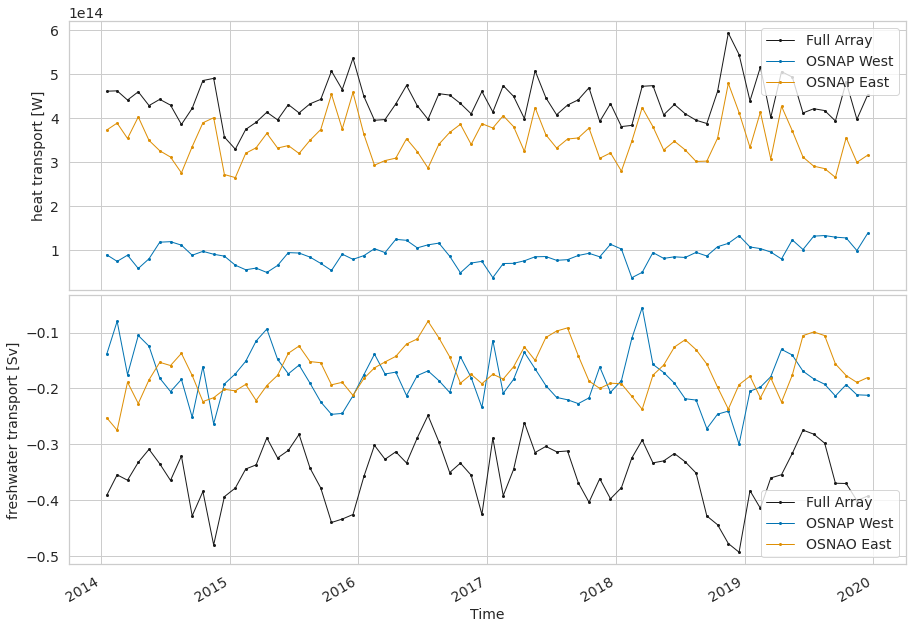

In [196]:
plot_MHT_MFT(transport_osnap,
             transport_owest,
             transport_oeast)
plt.savefig(path_figures / 'Viking20x_OSNAP_MHT_MFT_2014-19.png',bbox_inches="tight")

## plot overturning timeseries

In [197]:
def plot_amoc_timeseries(amoc_osnap_sum,amoc_osnap_w_sum,amoc_osnap_e_sum):
    fig, ax = plt.subplots(figsize=(15,5))
    ((amoc_osnap_sum).isel(vosigma0_bin=amoc_osnap_sum.argmax(dim="vosigma0_bin").compute())
        .plot(ax=ax,x="time_counter",marker='o',ms=2,linewidth=1,color='k',label='Full Array'))
    ((amoc_osnap_w_sum).isel(vosigma0_bin=amoc_osnap_w_sum.argmax(dim="vosigma0_bin").compute())
        .plot(ax=ax,x="time_counter",marker='o',ms=2,linewidth=1,color='C0',label='OSNAP West'))
    ((amoc_osnap_e_sum).isel(vosigma0_bin=amoc_osnap_e_sum.argmax(dim="vosigma0_bin").compute())
        .plot(ax=ax,x="time_counter",marker='o',ms=2,linewidth=1,color='C1',label='OSNAP East'))

    ax.legend();
    ax.set_ylim(bottom=-5)
    ax.set_ylim(top=30)
    # plt.savefig('Viking20x_OSNAP_MOC_timeseries.png')
    return


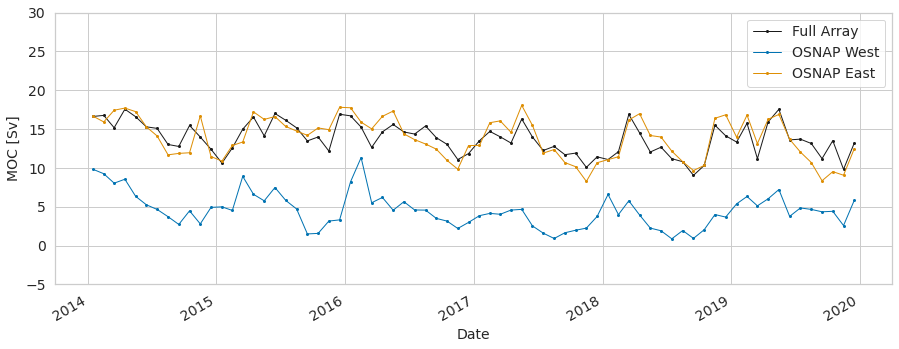

In [198]:
plot_amoc_timeseries(amoc_osnap_sumup,
                     amoc_owest_sumup,
                     amoc_oeast_sumup)
plt.savefig(path_figures / 'Viking20x_OSNAP_MOC_2014-19.png',bbox_inches='tight')

In [200]:
moc_osnap = (amoc_osnap_sumup).isel(vosigma0_bin=amoc_osnap_sumup.argmax(dim="vosigma0_bin").compute())
moc_owest = (amoc_owest_sumup).isel(vosigma0_bin=amoc_owest_sumup.argmax(dim="vosigma0_bin").compute())
moc_oeast = (amoc_oeast_sumup).isel(vosigma0_bin=amoc_oeast_sumup.argmax(dim="vosigma0_bin").compute())


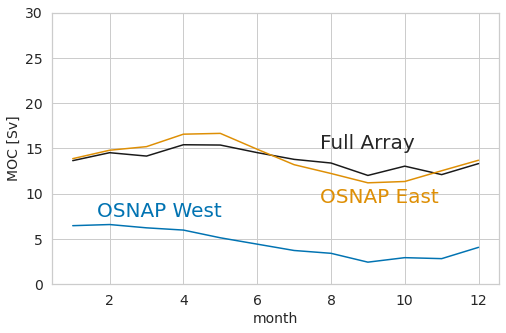

In [208]:
fig, ax = plt.subplots(figsize=(8,5))
moc_osnap.groupby(moc_osnap.time_counter.dt.month).mean().plot(color='k')
moc_owest.groupby(moc_owest.time_counter.dt.month).mean().plot(color='C0')
moc_oeast.groupby(moc_oeast.time_counter.dt.month).mean().plot(color='C1')
ax.set_ylim(0,30)
ax.text(0.6,0.5,'Full Array',fontsize=20,transform=ax.transAxes)
ax.text(0.1,0.25,'OSNAP West',color='C0',fontsize=20,transform=ax.transAxes)
ax.text(0.6,0.3,'OSNAP East',color='C1',fontsize=20,transform=ax.transAxes)
plt.savefig(path_figures / 'Viking20x_OSNAP_MOC_seasonal.png',bbox_inches='tight')

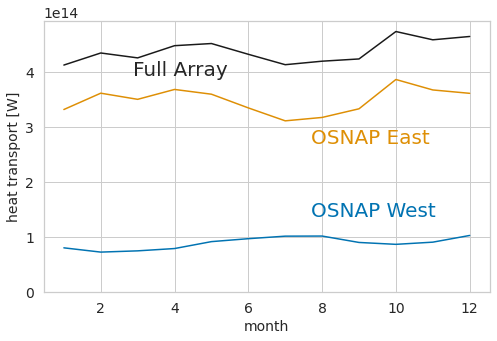

In [209]:
fig, ax = plt.subplots(figsize=(8,5))
transport_osnap.ht_trsp.groupby(transport_osnap.time_counter.dt.month).mean().plot(color='k')
transport_owest.ht_trsp.groupby(transport_owest.time_counter.dt.month).mean().plot(color='C0')
transport_oeast.ht_trsp.groupby(transport_oeast.time_counter.dt.month).mean().plot(color='C1')
ax.set_ylim(bottom=0)
ax.text(0.2,0.8,'Full Array',fontsize=20,transform=ax.transAxes)
ax.text(0.6,0.28,'OSNAP West',color='C0',fontsize=20,transform=ax.transAxes)
ax.text(0.6,0.55,'OSNAP East',color='C1',fontsize=20,transform=ax.transAxes)
plt.savefig(path_figures / 'Viking20x_OSNAP_MHT_seasonal.png',bbox_inches='tight')

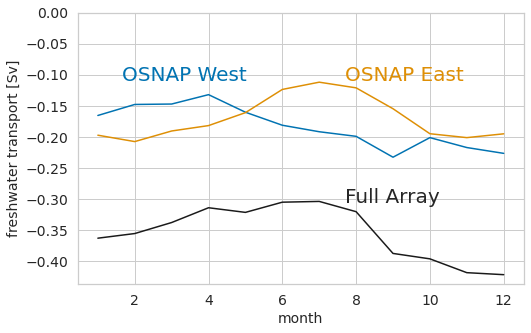

In [210]:
fig, ax = plt.subplots(figsize=(8,5))
transport_osnap.fw_trsp.groupby(transport_osnap.time_counter.dt.month).mean().plot(color='k')
transport_owest.fw_trsp.groupby(transport_owest.time_counter.dt.month).mean().plot(color='C0')
transport_oeast.fw_trsp.groupby(transport_oeast.time_counter.dt.month).mean().plot(color='C1')
ax.set_ylim(top=0)
ax.text(0.6,0.3,'Full Array',fontsize=20,transform=ax.transAxes)
ax.text(0.1,0.75,'OSNAP West',color='C0',fontsize=20,transform=ax.transAxes)
ax.text(0.6,0.75,'OSNAP East',color='C1',fontsize=20,transform=ax.transAxes)
plt.savefig(path_figures / 'Viking20x_OSNAP_MFW_seasonal.png',bbox_inches='tight')
